# 데이터 마이닝 팀프로젝트
  - 소재 : Network Intrusion Detection (네트워크 침입 탐지)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

## Import

In [43]:
# os, path
import os
import pathlib
from pathlib import Path

# tools
import itertools
import random
import pickle

# numpy, pandas
import numpy as np
import pandas as pd

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')

# 이미지
import requests
from PIL import Image
from io import BytesIO

# sklearn
from sklearn.model_selection import train_test_split,  GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MaxAbsScaler, MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score, recall_score, fbeta_score, make_scorer, confusion_matrix, plot_confusion_matrix

# Random forest
from sklearn.ensemble import RandomForestClassifier

# isolation forest
from sklearn.ensemble import IsolationForest

# XGBoost, Lightgbm
import xgboost as xgb

!pip install lightgbm
import lightgbm as lgb

# svm
from sklearn.svm import SVC

# warning
import warnings
warnings.filterwarnings(action='ignore') 

## Hyperparameters Setting

In [44]:
CFG = {
    'PATH': '/content/drive/MyDrive/Colab Notebooks/데이터마이닝/project',
    'SEED': 41,
    'COLORS': ['#CAF062', '#FABC55', '#E3595D', '#8755FA', '#51DEF0', '#52F261', '#FCBA3D', \
    '#E643DD', '#5BD7FF', '#C3F23A', '#E5F250', '#FC6C3A', '#6541E6']
    }

## Fix Randomseed and Path

In [45]:
# 튜닝
def set_env(path, seed):
  np.random.seed(seed)
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  os.chdir(path)

set_env(CFG['PATH'],CFG['SEED'])

## EDA Function

In [46]:
# 이미지 로드 함수
def open_img(url, title=None, headers={"User-Agent" : "Mozilla/5.0"}):

  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  plt.figure(figsize=(12, 7))
  plt.title(title, fontsize=20)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img)
  plt.show()

# 다수의 표를 그리는 함수
def bake_pies(data_list,labels, title):
    list_length = len(data_list)
    
    color_list = sns.color_palette()
    color_cycle = itertools.cycle(color_list)
    cdict = {}
    
    fig, axs = plt.subplots(1, list_length,figsize=(15,7), tight_layout=False)
    plt.subplots_adjust(wspace=1/list_length)
    
    for count, data_set in enumerate(data_list): 
        
        for num, value in enumerate(np.unique(data_set.index)):
            if value not in cdict:
                cdict[value] = next(color_cycle)
       
        wedges,texts = axs[count].pie(data_set,
                           colors=[cdict[v] for v in data_set.index])

        axs[count].legend(wedges, data_set.index,
                           title=title,
                           loc="center left",
                           bbox_to_anchor=(1, 0, 0.5, 1))

        axs[count].set_title(labels[count])
        
    return axs   

## Data Overview



```
논문 및 데이터 제공(NSL-KDD)은 Attack Type을 아래 그림과 같이 4가지 형태로 분류하였습니다.

Dos: 공격자가 시스템 자원을 점유하거나, 장애를 발생시키는 공격
R2L: 공격자가 호스트의 취약점을 이용하여 공격하는 방법
U2L: 공격자가 일반 사용자의 권한으로 접근하는 공격
Probe: 다른 공격을 준비하는 단계로 정보를 획득하고 취약점을 찾는 공격

따라서, DataLoader할 때, 다양한 공격을 4가지의 공격 패턴과 others(다른 부류)로 묶어서 전처리하여 새로운 attack_type 컬럼을 생성할 예정입니다.

또한, attack_flag('normal' = 0, 'abnormal' = 1)이라는 새로운 컬럼을 생성할 예정입니다.

```



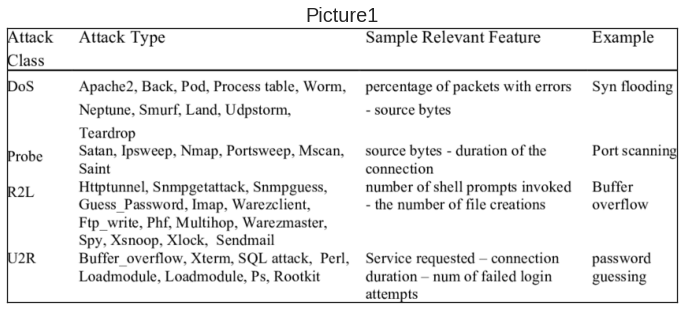

In [ ]:
open_img('https://www.researchgate.net/profile/Ahmed-Mahfouz-8/publication/335430444/figure/tbl1/AS:796531108085762@1566919223824/NSL-KDD-attack-types-and-classes.png', 'Picture1')

## Data Loader

In [47]:
class DataLoader():

  def __init__(self, path):

    self.columns = ['duration' ,'protocol_type' ,'service' ,'flag' ,'src_bytes' ,'dst_bytes','land',
                    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
                    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
                    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate',
                    'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 
                    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
                    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                    'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
                    'dst_host_srv_rerror_rate', 'attack', 'level']

    self.attack = {
                  'dos_attacks': ['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],                 
                  'probe_attacks': ['ipsweep','mscan','nmap','portsweep','saint','satan'],
                  'privilege_attacks': ['buffer_overflow','loadmdoule','perl','ps','rootkit','sqlattack','xterm'],
                  'access_attacks': ['ftp_write','guess_passwd','http_tunnel','imap','multihop','named','phf','sendmail', \
                                  'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xclock','xsnoop'],
                  'attack_labels': ['Normal','DoS','Probe','Privilege','Access']
                  }

    self.path = path

    # 데이터 처리
    self.data = pd.DataFrame(data=pd.read_csv(self.path))
    self.data.columns=self.columns

    # 공격 타입 판단
    self.data['attack_type'] = self.data['attack'].apply(lambda x: 1 if x in self.attack['dos_attacks'] \
                                                         else 2 if x in self.attack['probe_attacks'] \
                                                         else 3 if x in self.attack['privilege_attacks'] \
                                                         else 4 if x in self.attack['access_attacks'] \
                                                         else 0)

    # 공격 유무 판단
    self.data['attack_flag'] = self.data['attack'].apply(lambda x: 0 if x == 'normal' else 1)

  def __return__(self):
    return self.data  

In [48]:
# 데이터 불러오기

nsl_train_20_percent_path = CFG['PATH'] + '/data/KDDTrain+_20Percent.txt'
nsl_train_full_path = CFG['PATH'] + '/data/KDDTrain+.txt'
nsl_test_full_path = CFG['PATH'] + '/data/KDDTest+.txt' 

# 데이터프레임
df = DataLoader(nsl_train_20_percent_path).data
train_df = DataLoader(nsl_train_full_path).data
test_df = DataLoader(nsl_test_full_path).data

## EDA



```
현재 데이터에는 int, float, object형태로 구성되어 있습니다.
숫자형의 경우 데이터가 바이트, 혹은 연속형 분포로 되어있다면   
그대로 활용할 예정이고, 만약 범주형 순서일 경우 재전처리를 할 예정입니다.

반면, object형의 경우 적절한 레이블 형태의 전처리가 필요하므로
protocal_type, service, flag 3개의 컬럼을 시각화하였습니다.

protocal_type은 tcp, udp, icmp로 3가지 이므로 파이차트와 막대그래프를 통해 확인할 수 있었고,
나머지 두개의 컬럼은 고유 샘플 개수가 많으므로 파이차트로 확인하였습니다.
```



### Categorical type

In [ ]:
# 데이터 타입 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25191 entries, 0 to 25190
Data columns (total 45 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25191 non-null  int64  
 1   protocol_type                25191 non-null  object 
 2   service                      25191 non-null  object 
 3   flag                         25191 non-null  object 
 4   src_bytes                    25191 non-null  int64  
 5   dst_bytes                    25191 non-null  int64  
 6   land                         25191 non-null  int64  
 7   wrong_fragment               25191 non-null  int64  
 8   urgent                       25191 non-null  int64  
 9   hot                          25191 non-null  int64  
 10  num_failed_logins            25191 non-null  int64  
 11  logged_in                    25191 non-null  int64  
 12  num_compromised              25191 non-null  int64  
 13  root_shell      

In [ ]:
# tcp 유형의 공격이 제일 많은 빈도수 차지
attack_vs_protocol = pd.crosstab(df.attack, df.protocol_type)
attack_vs_protocol

protocol_type,icmp,tcp,udp
attack,,,
back,0,196,0
buffer_overflow,0,6,0
ftp_write,0,1,0
guess_passwd,0,10,0
imap,0,5,0
ipsweep,609,101,0
land,0,1,0
loadmodule,0,1,0
multihop,0,2,0


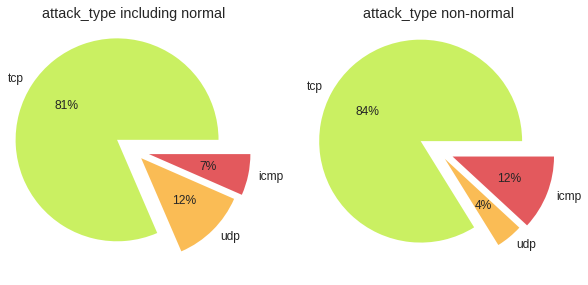

In [49]:
# protocol 대비 공격빈도 파이차트

plt.rcParams["font.size"] = 12
plt.figure(figsize=(10, 10))

condition_p = set(df.protocol_type)

for idx, n in enumerate(['', 'normal']):
  plt.subplot(1, 2, idx+1)
  condition_len_ = []
  for s in condition_p:
    condition_len_.append(np.sum(((df.protocol_type == s) & (df.attack != n))))

  plt.pie(condition_len_, labels = condition_p, colors=CFG['COLORS'], autopct='%.0f%%', explode=[0.2, 0.1, 0.15])
  if n == '':
    plt.title('attack_type including normal')
  else:
    plt.title('attack_type non-normal')

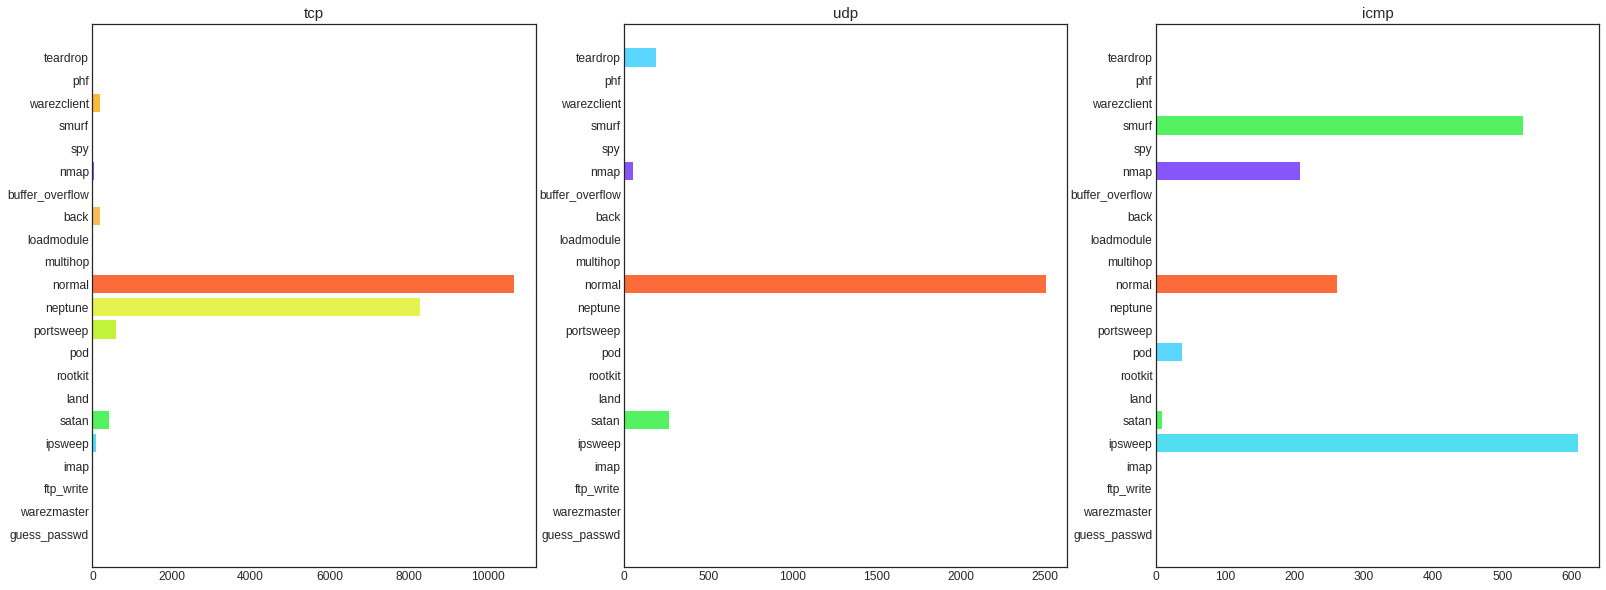

In [50]:
# 각 프로토콜 형태로 공격에 해당하는 막대 그래프

condition = set(df['attack'])
plt.figure(figsize=(27, 10))

for idx, t in enumerate(condition_p):
  plt.subplot(1, 3, idx+1)
  condition_len_ = []
  for att in condition:
    condition_len_.append(np.sum((df.protocol_type == t) & (df.attack == att)))
  plt.barh(list(condition), condition_len_, color=CFG['COLORS'])
  plt.title(t, fontsize=15)

plt.show()

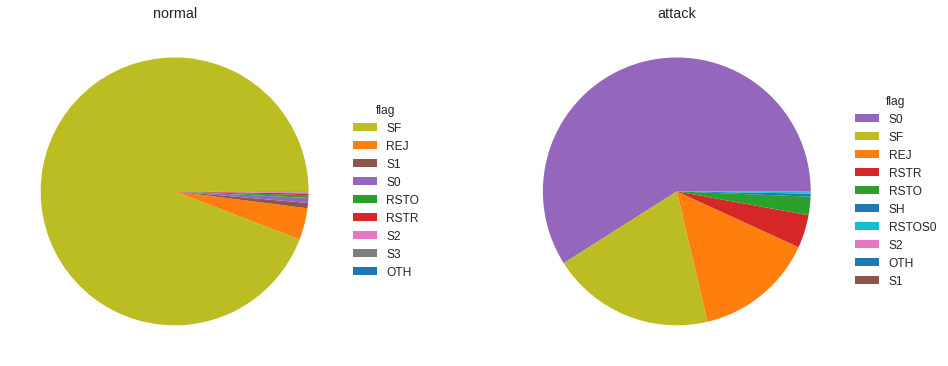

In [51]:
# 플래그 형태의 normal과 attack 파이차트

normal_flags = df.loc[df.attack_flag == 0].flag.value_counts()
attack_flags = df.loc[df.attack_flag == 1].flag.value_counts()

flag_axs = bake_pies([normal_flags, attack_flags], ['normal','attack'],'flag')        
plt.show()

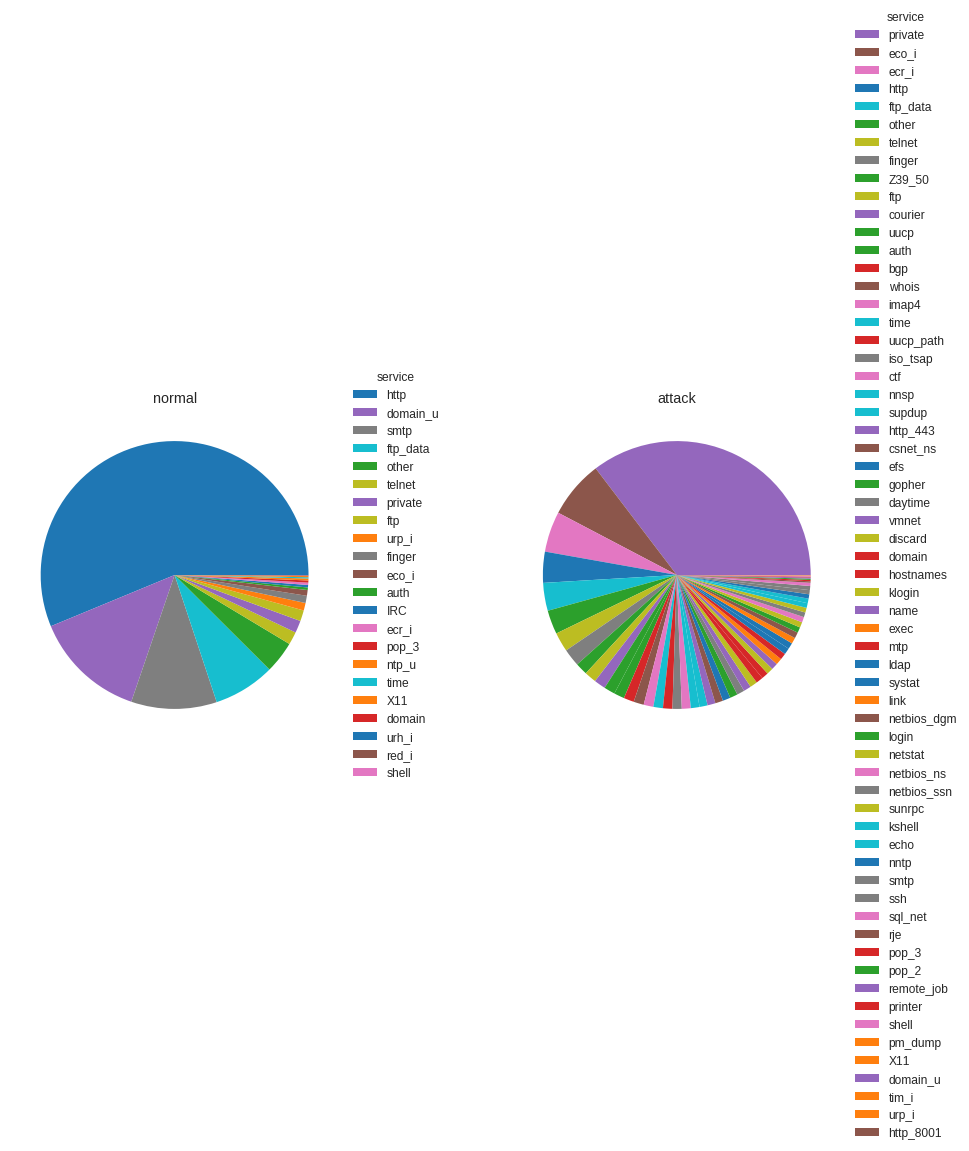

In [52]:
normal_services = df.loc[df.attack_flag == 0].service.value_counts()
attack_services = df.loc[df.attack_flag == 1].service.value_counts()

service_axs = bake_pies([normal_services, attack_services], ['normal','attack'], 'service')        
plt.show()

### numerical type



```
주어진 데이터가 시계열데이터는 아니지만, byte 혹은 비율 등 수치형 자료라는 특성을 활용하여 plot을 그려보았습니다.

이를 통해 normal일 때와 공격일 때 어떠한 데이터의 분포 차이가 있는지 확인할 수 있었습니다.

```



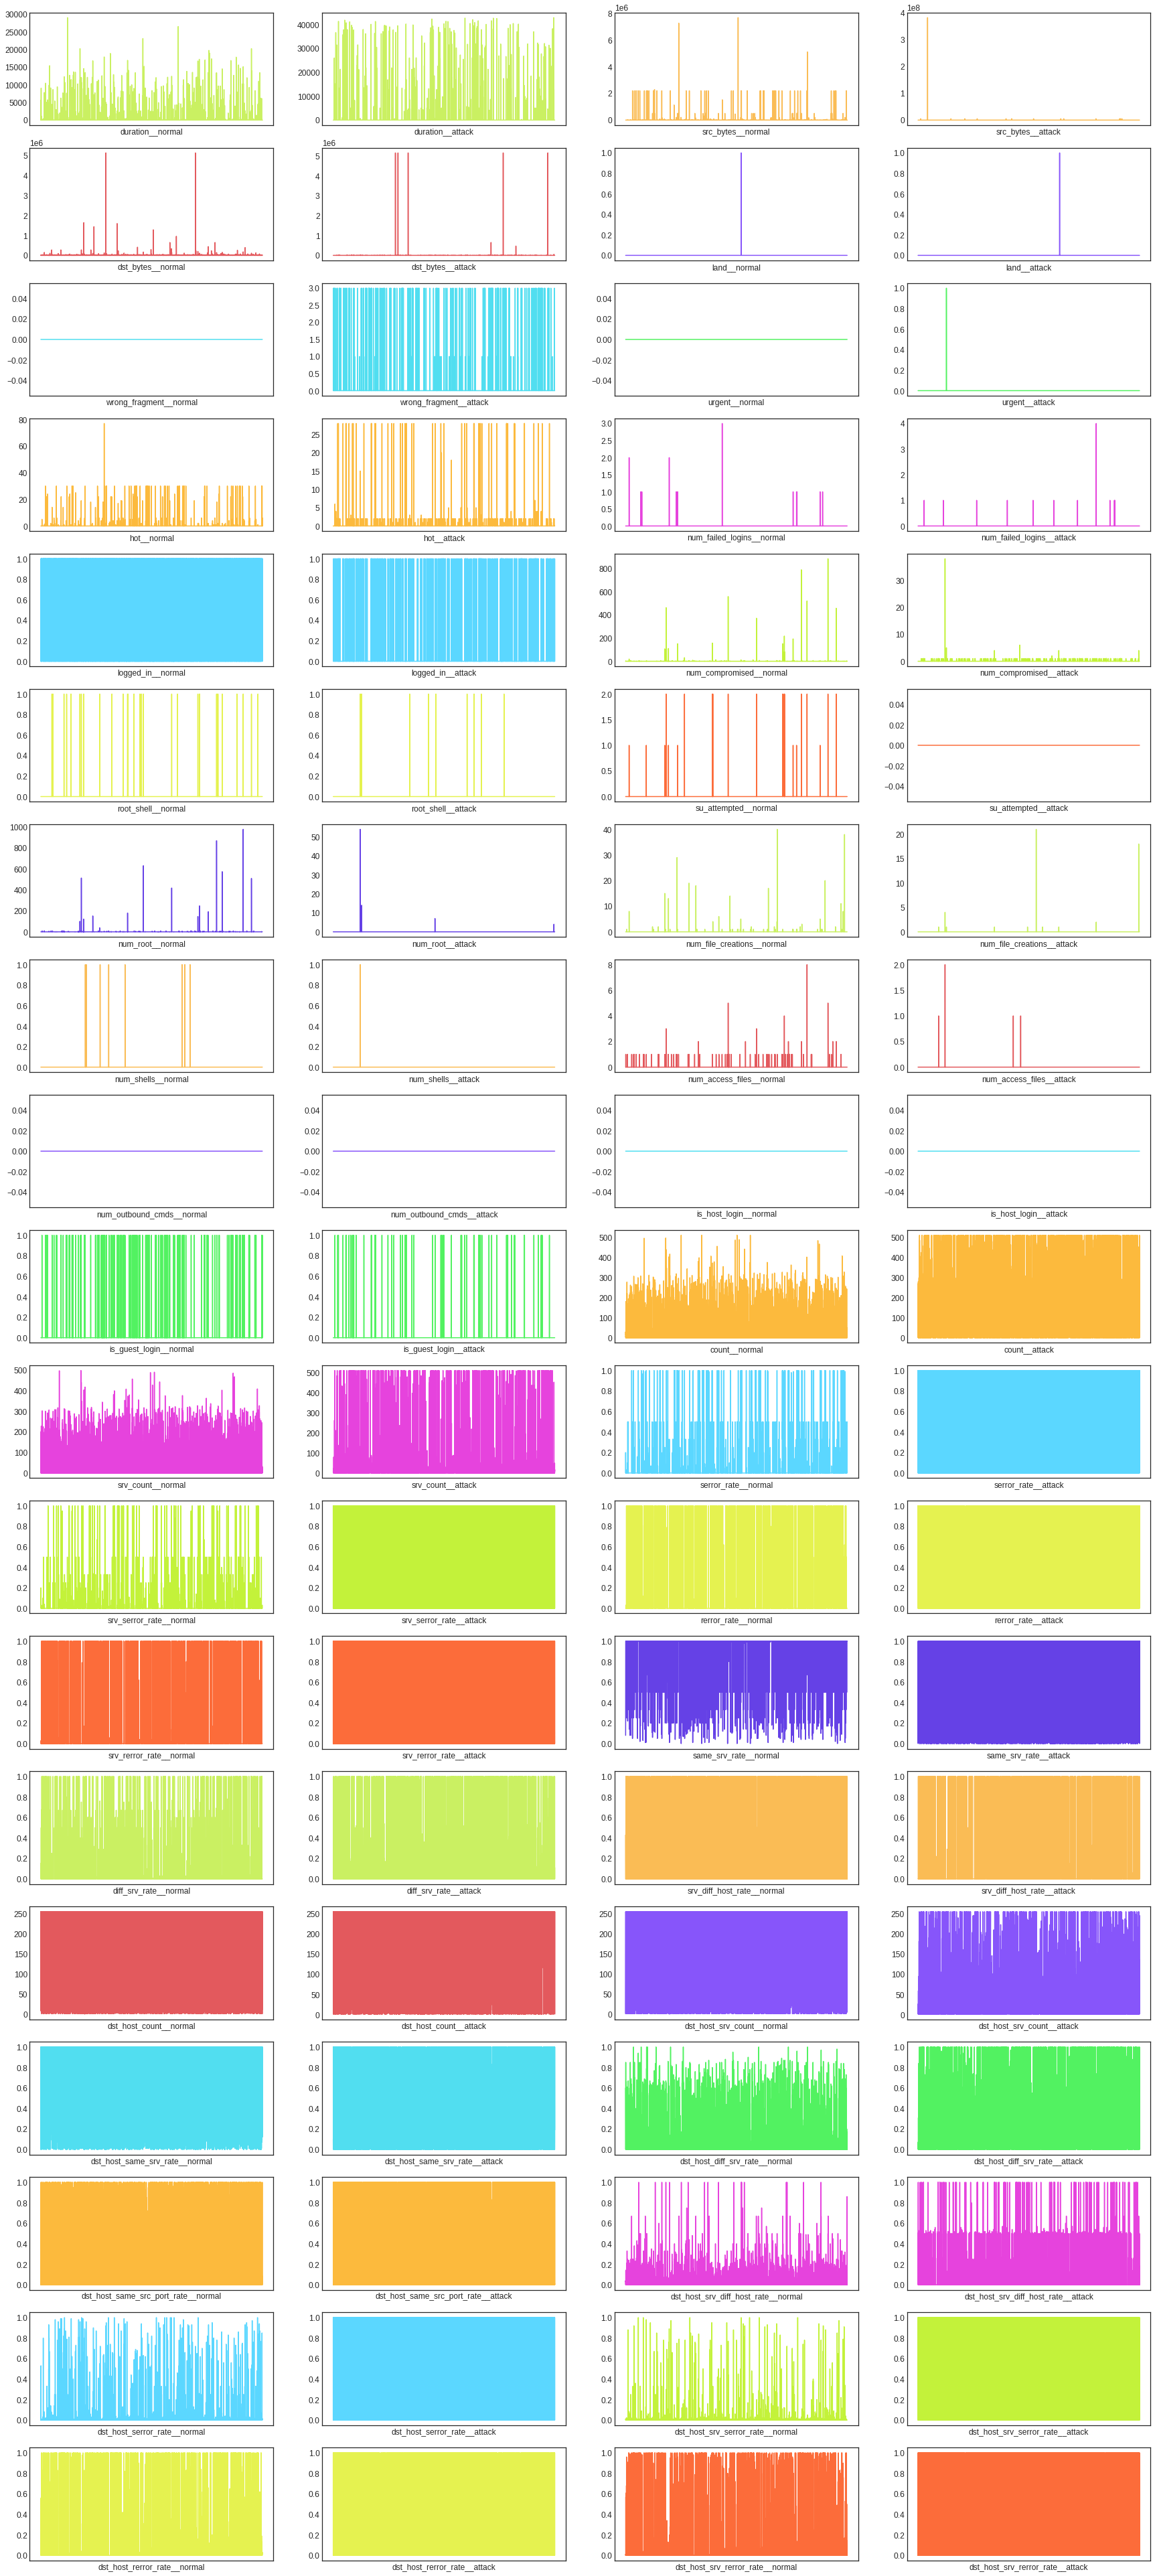

In [53]:
# 수치형 컬럼 정의
numeric_col = [t for t in df.columns if df[t].dtype in ['int64', 'float64'] and t not in ['attack', 'level', 'attack_type', 'attack_flag'] ]

plt.figure(figsize=(30, 70))

for idx, c in enumerate(numeric_col):
  plt.subplot(19, 4, 2*idx+1)
  condition = np.where(df.attack_flag == 0)[0]
  plt.plot(range(len(condition)), df.loc[condition, c], color=CFG['COLORS'][idx % len(CFG['COLORS'])])
  plt.xticks([])
  plt.xlabel(c + '__normal')

  plt.subplot(19, 4, 2*idx+2)
  condition = np.where(df.attack_flag == 1)[0]
  plt.plot(range(len(condition)), df.loc[condition, c], color=CFG['COLORS'][idx % len(CFG['COLORS'])])
  plt.xticks([])
  plt.xlabel(c + '__attack')

## Data processing



```
데이터 전처리 순서는

1. X_train과 X_test의 범주형 자료는 동일한 원핫 인코딩
2. 데이터 분할
3. 데이터 스케일링

순서로 진행할 예정이며 전체 훈련 데이터셋은 데이터 개수가 많아서 
X_train, y_train에서 20%만 추출한 X_train_20, y_train_20을 사용하겠습니다.

그리드 서치를 사용할 예정이지만, 그리드서치한 결과를 판단하기 위해   
validation_set을 일부 만들어 놓겠습니다

추후 모델이 선정되면 X_train을 활용하여 파라미터를 최적화할 예정입니다.  

데이터 스케일링은
1. MinMaxScaler
2. RobustScaler
3. StandardScaler

세 가지를 모두 활용하여 
X_train_20으로 fit 한 후 , X_train_20과 X_val_20에 적용시키겠습니다.

스케일링도 하나의 파라미터로 생각하여 모델에 적용할 예정입니다.
```



In [54]:
def train_processing(df, drop_columns=['attack', 'level'], label='attack_flag'):
  """
  df: 데이터프레임
  drop_columns: 원핫인코딩에 적용하지 않거나, 제거할 object columns
  label: 데이터프레임에서 분리할 정답 레이블
  return: 원핫인코딩이 적용된 데이터프레임, 정답레이블, service dict, flag dict, 원핫인코더
  """

  df = df.drop(drop_columns, axis=1)
  label_ = df.pop('attack_flag')

  df['protocol_type'] = df['protocol_type'].apply(lambda x: 1 if x == 'tcp' \
                                                else 2 if x == 'udp' \
                                                else 3 if x == 'icmp' \
                                                else 4)
  
  service = {}
  for idx, i in enumerate(set(df['service'])):
    service[i] = idx

  flag = {}
  for idx, i in enumerate(set(df['flag'])):
    flag[i] = idx

  df['service'] = df['service'].apply(lambda x: service[x] if x in service.keys() else -1)
  df['flag'] = df['flag'].apply(lambda x: flag[x] if x in flag.keys() else -1)

  for c in ['protocol_type', 'attack_type', 'flag', 'service']:
    df[c] = df[c].astype('object')
  df_temp = df[['protocol_type', 'attack_type', 'flag', 'service']]
  
  oh_encoder = OneHotEncoder()
  oh_encoder.fit(df_temp)
  df_temp = oh_encoder.transform(df_temp).toarray()

  df = df.drop(['protocol_type', 'attack_type', 'flag', 'service'], axis=1).to_numpy()
  df = np.concatenate((df, df_temp), axis=1)

  return df, label_.to_numpy(), service, flag, oh_encoder


#########################################################################################################

def test_processing(df, service, flag, oh_encoder, drop_columns=['attack', 'level'], label='attack_flag'):
  """
  df: 데이터프레임
  service: X_train에 해당하는 serivce 레이블을 train에 그대로 적용하기 위한 고유 샘플 딕셔너리
  flag: X_train에 해당하는 flag 레이블을 train에 그대로 적용하기 위한 고유 샘플 딕셔너리
  on_encoder: X_train에 적용된 onehot인코더
  drop_columns: 원핫인코딩에 적용하지 않거나, 제거할 object columns
  label: 데이터프레임에서 분리할 정답 레이블
  return: 원핫인코딩이 적용된 데이터프레임, 정답레이블  
  """

  df = df.drop(drop_columns, axis=1)
  label_ = df.pop('attack_flag')

  df['protocol_type'] = df['protocol_type'].apply(lambda x: 1 if x == 'tcp' \
                                                else 2 if x == 'udp' \
                                                else 3 if x == 'icmp' \
                                                else 4)
    
  df['flag'] = df['flag'].apply(lambda x: flag[x] if x in flag.keys() else -1)
  df['service'] = df['service'].apply(lambda x: service[x] if x in service.keys() else -1)

  for c in ['protocol_type', 'attack_type', 'flag', 'service']:
    df[c] = df[c].astype('object')
  df_temp = df[['protocol_type', 'attack_type', 'flag', 'service']]
  
  df_temp = oh_encoder.transform(df_temp).toarray()

  df = df.drop(['protocol_type', 'attack_type', 'flag', 'service'], axis=1).to_numpy()
  df = np.concatenate((df, df_temp), axis=1)

  return df, label_.to_numpy()


# 전처리 적용
X_20, y_20, _, _, _ = train_processing(df)
X_train_full, y_train_full, service, flag, oh_encoder = train_processing(train_df)
X_test, y_test = test_processing(test_df, service, flag, oh_encoder)

# train_
X_train_20, X_val_20, y_train_20, y_val_20 = train_test_split(X_20, y_20, train_size=0.8, stratify=y_20, random_state = CFG['SEED'])

In [55]:
# 변수 초기화
scalers = [mm, rob, std] = [MinMaxScaler(), RobustScaler(), StandardScaler()]
X_train_scale, X_val_scale = [0]*len(scalers), [0]*len(scalers),

# MaxAbsScaler(), MinMaxScaler(), RobustScaler(), StandardScaler()로 스케일 적용
for idx, (sc, train, val) in enumerate(zip(scalers, X_train_scale, X_val_scale)):
  sc.fit(X_train_20)
  train = sc.transform(X_train_20)
  val = sc.transform(X_val_20)

  X_train_scale[idx] = train
  X_val_scale[idx] = val

# 스케일 언패킹하여 적용
X_train_20_mm, X_train_20_rob, X_train_20_std = X_train_scale
X_val_20_mm, X_val_20_rob, X_val_20_std = X_val_scale

# Trainning Model



```
적용 모델링

1. RandomForest
2. XGboost
3. lightgbm
4. Isolation forest
5. SVM

적용 metrics:
fbeta_score


앙상블 모델은 스케일링에 민감하지 않으므로 RandomForst, XGboost,   
lightgbm, isolation forest는 X_train 데이터에 각 모델의 파라미터로 grid   
search를 적용하겠습니다.

그 외 모델은 for문으로 스케일링이 적용된 각 데이터셋을 grid search 적용하여,  
최적의 파라미터(스케일, 각 모델에 적용되는 파라미터)를 찾아서 성능비교를 할 예정입니다.

적용 모델로 fbeta_score를 적용한 이유는 다음과 같습니다.
f1_score의 경우 precision = 0.6 , recall = 0.4인 것과
precision = 0.4, recall = 0.6인 경우는 0.48로 같습니다.

하지만, 컴퓨터 보안과 같은 anormaly detection에서는 
recall이 상대적으로 precision보다 중요하다고 판단하여
fbeta_score를 metrics로 선정하였습니다.
모델 선정에 사용할 beta는 2입니다


마지막은 최종적으로 성능이 좋았던 모델을 간추려 X_train셋에 적용하여 
재테스트를 한 후 최종적인 모델을 선정하겠습니다.
```



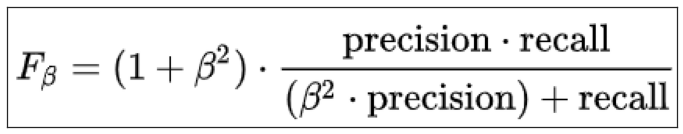

In [ ]:
# define fbeta_score

open_img('https://postfiles.pstatic.net/MjAxOTA1MDhfMjQz/MDAxNTU3MjQzNjI0MzUy.6JgNuTiXFI6uU7OiMYX_RirzxSMIu9J0PoqSbeXZX30g.bz5kazMXgOn0YTa6uFQ2wbaC7maUFC0R_yscB-ISrQQg.PNG.wideeyed/555.png?type=w773')

In [56]:
# model metrics

ftwo_scorer = make_scorer(fbeta_score, beta=2)
ftwo_scorer

best_fbeta_model_, best_fbeta_model_score_ = [], []

## RandomForest

In [ ]:
# 모든 모델의 성능을 저장할 Best Model_fbeta score list

rf_params = {'max_depth' : [md for md in range(1, 10)], 'min_samples_leaf' : [md for md in range(1, 10)], \
             'min_samples_split' : [md for md in range(1, 10)]}

rf_model = RandomForestClassifier(n_estimators=100, random_state = CFG['SEED'])

rf_grid = GridSearchCV(rf_model, param_grid = rf_params, refit=True, n_jobs = -1, scoring=ftwo_scorer)
rf_grid.fit(X_train_20, y_train_20)

print(f'GridSearchCV 최적 파라미터: {rf_grid.best_params_}')
print(f'GridSearchCV 최고 fbeta: {rf_grid.best_score_:.4f}')

# validation set 적용 결과
rf_model = rf_grid.best_estimator_

rf_model.fit(X_train_20, y_train_20)
y_val_20_pred = rf_model.predict(X_val_20)

rf_fbeta = fbeta_score(y_val_20, y_val_20_pred, beta=2)

best_fbeta_model_.append(rf_model)
best_fbeta_model_score_.append(rf_fbeta)
print(f'fbeta score: {rf_fbeta}')

GridSearchCV 최적 파라미터: {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2}
GridSearchCV 최고 fbeta: 0.9999
fbeta score: 1.0


##XGBoost

In [ ]:
xgb_params = {'learning_rate' : [0.01, 0.03, 0.08], 'gamma' : [0, 1, 10], 'max_depth' : [1, 3, 5, 6, 7]}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, subsample=0.75,
                              colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'])


xgb_grid = GridSearchCV(xgb_model, param_grid = xgb_params, refit=True, n_jobs = -1, scoring=ftwo_scorer)
xgb_grid.fit(X_train_20, y_train_20)

print(f'GridSearchCV 최적 파라미터: {xgb_grid.best_params_}')
print(f'GridSearchCV 최고 fbeta: {xgb_grid.best_score_:.4f}')

# validation set 적용 결과
xgb_model = xgb_grid.best_estimator_

xgb_model.fit(X_train_20, y_train_20)
y_val_20_pred = xgb_model.predict(X_val_20)


xgb_fbeta = fbeta_score(y_val_20, y_val_20_pred, beta=2)

best_fbeta_model_.append(xgb_model)
best_fbeta_model_score_.append(xgb_fbeta)
print(f'fbeta score: {xgb_fbeta}')

GridSearchCV 최적 파라미터: {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 1}
GridSearchCV 최고 fbeta: 0.9999
fbeta score: 1.0


## Light GBM

In [ ]:
lgb_params = {'learning_rate' : [0.01, 0.03, 0.08]}

lgb_model = lgb.LGBMClassifier(objective='binary', n_estimators=100, subsample=0.75,
                              colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'])


lgb_grid = GridSearchCV(lgb_model, param_grid = lgb_params, refit=True, n_jobs = -1, scoring=ftwo_scorer)
lgb_grid.fit(X_train_20, y_train_20)

print(f'GridSearchCV 최적 파라미터: {lgb_grid.best_params_}')
print(f'GridSearchCV 최고 fbeta: {lgb_grid.best_score_:.4f}')

# validation set 적용 결과
lgb_model = lgb_grid.best_estimator_

lgb_model.fit(X_train_20, y_train_20)
y_val_20_pred = lgb_model.predict(X_val_20)

lgb_fbeta = fbeta_score(y_val_20, y_val_20_pred, beta=2)

best_fbeta_model_.append(lgb_model)
best_fbeta_model_score_.append(lgb_fbeta)
print(f'fbeta score: {lgb_fbeta}')

GridSearchCV 최적 파라미터: {'learning_rate': 0.01}
GridSearchCV 최고 fbeta: 0.9999
fbeta score: 1.0


## SVM

In [ ]:
svm_params = {'C' : [10**(-3 + i) for i in range(1, 6)], 'kernel': ['rbf'], \
              'gamma' : [10**(-3 + i) for i in range(1, 4)]}

svm_model = SVC(random_state=CFG['SEED'])
svm_grid = GridSearchCV(svm_model, param_grid = svm_params, refit=True, n_jobs = -1, scoring=ftwo_scorer)
best_score = best_idx = -1

# idx를 활용하여 최적의 그리드서치 fbeta 스코어를 찾았을 때, idx를 저장
for idx, X_train_20_sc in enumerate(X_train_scale):
  svm_grid.fit(X_train_20_sc, y_train_20)

  if svm_grid.best_score_ > best_score:
    best_score = svm_grid.best_score_
    best_idx = idx

print(f'GridSearchCV 최적 파라미터: {svm_grid.best_params_}')
print(f'GridSearchCV 최고 fbeta: {svm_grid.best_score_:.4f}')
print(f'GridSearchCV 최고 scaler: {(lambda x: "MinMax" if x == 0 \
                                  else "Robust" if x == 1 else "Standard")(best_idx)}')

# validation set 적용 결과
svm_model = svm_grid.best_estimator_

lgb_model.fit(X_train_scale[idx], y_train_20)
y_val_20_pred = lgb_model.predict(X_val_scale[idx])

svm_fbeta = fbeta_score(y_val_20, y_val_20_pred, beta=2)

best_fbeta_model_.append([svm_model, idx])
best_fbeta_model_score_.append(svm_fbeta)
print(f'fbeta score: {svm_fbeta}')

GridSearchCV 최적 파라미터: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
GridSearchCV 최고 fbeta: 0.9989
GridSearchCV 최고 scaler: MinMax
fbeta score: 1.0


# Model Selection

## Model metrics and Apply Test data


```
각 모델의 그리드서치 결과, 가장 좋은 성능을 보였던 모델은
XGboost와 lightboost,SVM입니다.
특히 lightboost는 매우 빠른 속도를 보였습니다.
따라서, sklearn에서 제공하는 fbeata_score를 이용하여 빠르고 높은 성능을 보였던 
lightlgb 모델로 learning_rate 및 max_depth를 조절해가면서 결과를 최적화하는 작업을 수행하겠습니다.

선정한 최적의 모델들을 전체 train_set에 접목시켜서 최적의 fbeta 스코어를 찾는 과정입니다.
과정은 cross validation을 적용하여 fbeta 스코어 및  Recall을 최소로 하는 모델을 선정하겠습니다.

```




In [ ]:
df_model = pd.DataFrame({'best_model': best_fbeta_model_, 'best_fbeat_score': best_fbeta_model_score_})

df_model

,best_model,best_fbeat_score
0,"(DecisionTreeClassifier(max_depth=8, max_featu...",1.0
1,"XGBClassifier(colsample_bytree=0.8, learning_r...",1.0
2,"LGBMClassifier(colsample_bytree=0.8, learning_...",1.0
3,"[SVC(C=10, gamma=0.01, random_state=41), 2]",1.0


In [ ]:
# 전체 데이터로 beta, 및 파라미터 그리드 서치

lgb_score_ = []
params = []


lgb_params = {'learning_rate' : np.linspace(0.01, 0.1, 10)}

scoring = {'recall_score': make_scorer(recall_score),
          'fbeta_score': make_scorer(fbeta_score, beta=2)}


for lr in lgb_params['learning_rate']:
  for md in [md for md in range(1, 10)]:
    
    params.append([lr, md])

    lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=lr, n_estimators=100, subsample=0.75, 
                                colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                                max_depth=md)

    lgb_score = cross_validate(lgb_model, X_train_full, y_train_full, scoring=scoring)
    lgb_score_.append(lgb_score)

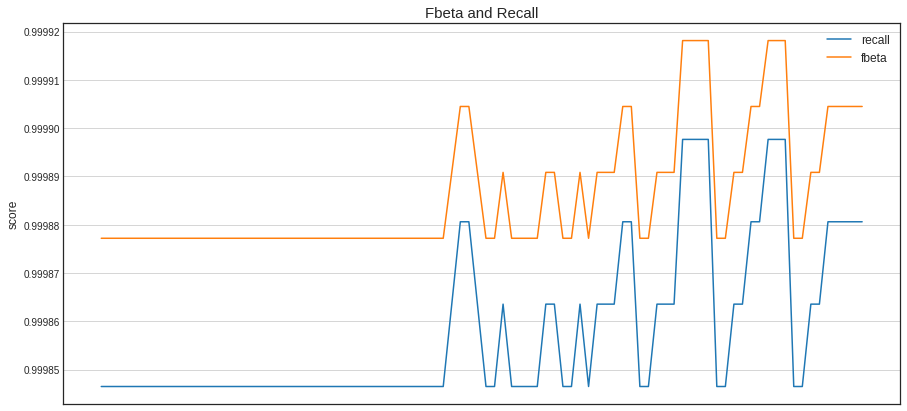

In [ ]:
# fbeta score 그래프 확인

plt.figure(figsize=(15, 7))
mean_recall, mean_fbeta = [], []

for lgb_s in lgb_score_:
  mean_recall.append(np.mean(lgb_s['test_recall_score']))
  mean_fbeta.append(np.mean(lgb_s['test_fbeta_score']))

index = []
for param in params:
  index.append('lr: '+str(param[0])+' md: '+str(param[1]))

plt.plot(np.arange(len(index)), mean_recall, label='recall')
plt.plot(np.arange(len(index)), mean_fbeta, label='fbeta')
plt.title('Fbeta and Recall', fontsize=15)
plt.xlabel('')
plt.ylabel('score', fontsize=12)
plt.grid()
plt.xticks([])
plt.legend(fontsize=12)

In [ ]:
print(f'최적의 Fbeta:  learning_rate: {params[np.argmax(mean_fbeta)][0]} \t최적의 max_depth: {params[np.argmax(mean_fbeta)][1]}')
print(f'최적의 Recall: learning_rate: {params[np.argmax(mean_recall)][0]} \t최적의 max_depth: {params[np.argmax(mean_recall)][1]}')

최적의 Fbeta:  learning_rate: 0.08 	최적의 max_depth: 6
최적의 Recall: learning_rate: 0.08 	최적의 max_depth: 6


Text(0.5, 1.0, 'Confusion Matrix')

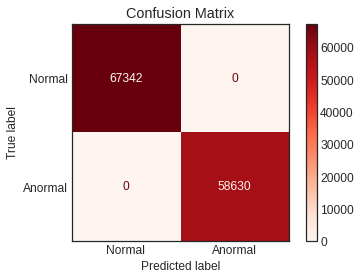

In [57]:
lgb_model = lgb.LGBMClassifier(objective='binary', learning_rate=0.08, n_estimators=100, subsample=0.75, 
                            colsample_bytree=0.8, tree_method='gpu_hist', random_state=CFG['SEED'],
                            max_depth=6)

lgb_model.fit(X_train_full, y_train_full)

label=['Normal', 'Anormal']

plot = plot_confusion_matrix(lgb_model,
                             X_train_full, y_train_full,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

# Model Test

##### fbeta 스코어를 높이고 FN을 낮추는 것이 목표인데 FN(False Negative)가 1인 것을 확인할 수 있습니다.

##### 보안이라는 프로젝트 주제를 생각한다면, FN=0으로 하면서 FP를 낮추는 방향을 고려해야할 것으로 판단이 됩니다.

In [19]:
y_test_pred = lgb_model.predict(X_test)

print(f'최적의 fbeta 성능: {fbeta_score(y_test, y_test_pred, beta=2)}')

최적의 fbeta 성능: 0.9909867691394472


Text(0.5, 1.0, 'Confusion Matrix')

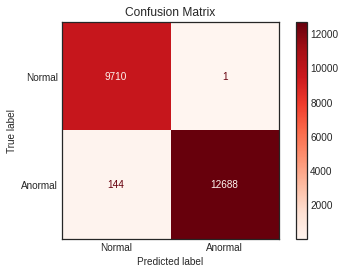

In [20]:
label=['Normal', 'Anormal']

plot = plot_confusion_matrix(lgb_model,
                             X_test, y_test,
                             display_labels=label,
                             cmap=plt.cm.Reds,
                             normalize=None)

plot.ax_.set_title('Confusion Matrix')

## Model save

In [24]:
with open('./save_model/save_model.pickle','wb') as fw:
  pickle.dump(lgb_model, fw)

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Pretrained model Processing
def train_processing(df, drop_columns=['attack', 'level'], label='attack_flag', pretrained=False):
  """
  df: 데이터프레임
  drop_columns: 원핫인코딩에 적용하지 않거나, 제거할 object columns
  label: 데이터프레임에서 분리할 정답 레이블
  pretrained: 사전에 학습한 모델의 전처리를 활용하려면 True, False라면 새롭게 X_Train 범주형 자료 전처리
  return: 원핫인코딩이 적용된 데이터프레임, 정답레이블, service dict, flag dict, 원핫인코더
  """

  df = df.drop(drop_columns, axis=1)
  label_ = df.pop('attack_flag')

  df['protocol_type'] = df['protocol_type'].apply(lambda x: 1 if x == 'tcp' \
                                                else 2 if x == 'udp' \
                                                else 3 if x == 'icmp' \
                                                else 4)
  
  if pretrained:
    service = {'IRC': 50, 'X11': 47, 'Z39_50': 65, 'aol': 43, 'auth': 11, 'bgp': 22, 'courier': 20, 'csnet_ns': 45,
               'ctf': 19, 'daytime': 31, 'discard': 57, 'domain': 7, 'domain_u': 51, 'echo': 64, 'eco_i': 28, 'ecr_i': 4,
               'efs': 27, 'exec': 3, 'finger': 33, 'ftp': 52, 'ftp_data': 56, 'gopher': 38, 'harvest': 17, 'hostnames': 41,
               'http': 53, 'http_2784': 67, 'http_443': 36, 'http_8001': 8, 'imap4': 13, 'iso_tsap': 25, 'klogin': 5, 'kshell': 44,
               'ldap': 63, 'link': 15, 'login': 46, 'mtp': 54, 'name': 39, 'netbios_dgm': 55, 'netbios_ns': 0, 'netbios_ssn': 24, 'netstat': 59,
               'nnsp': 60, 'nntp': 34, 'ntp_u': 49, 'other': 29, 'pm_dump': 26, 'pop_2': 2, 'pop_3': 35, 'printer': 16, 'private': 9, 'red_i': 14,
               'remote_job': 58, 'rje': 66, 'shell': 21, 'smtp': 18, 'sql_net': 42, 'ssh': 48, 'sunrpc': 6, 'supdup': 30, 'systat': 69, 'telnet': 1, 'tftp_u': 37,
               'tim_i': 32, 'time': 68, 'urh_i': 23, 'urp_i': 10, 'uucp': 61, 'uucp_path': 40, 'vmnet': 12, 'whois': 62}

    flag = {'OTH': 4, 'REJ': 7, 'RSTO': 0, 'RSTOS0': 10, 'RSTR': 2, 'S0': 5, 'S1': 3, 'S2': 6, 'S3': 1, 'SF': 9, 'SH': 8}

  else:
    service = {}
    for idx, i in enumerate(set(df['service'])):
      service[i] = idx
    flag = {}
    for idx, i in enumerate(set(df['flag'])):
      flag[i] = idx

  df['service'] = df['service'].apply(lambda x: service[x] if x in service.keys() else -1)
  df['flag'] = df['flag'].apply(lambda x: flag[x] if x in flag.keys() else -1)

  for c in ['protocol_type', 'attack_type', 'flag', 'service']:
    df[c] = df[c].astype('object')
  df_temp = df[['protocol_type', 'attack_type', 'flag', 'service']]
  
  oh_encoder = OneHotEncoder()
  oh_encoder.fit(df_temp)
  df_temp = oh_encoder.transform(df_temp).toarray()

  df = df.drop(['protocol_type', 'attack_type', 'flag', 'service'], axis=1).to_numpy()
  df = np.concatenate((df, df_temp), axis=1)

  return df, label_.to_numpy(), service, flag, oh_encoder
